In [19]:
import sys
import os
import pathlib
import torch

import numpy as np
import matplotlib.pyplot as plt

# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))


from models.unet_dropout import UNet_dropout

from utils.watertopo import WaterTopo
from utils.utils import recursive_pred, mse_per_timestep

%matplotlib inline

In [5]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Is CUDA enabled? False
Number of GPUs 0
Using device: cpu


We load in a random test simulation from test 1.

In [6]:
grid_size = 64
channels = 2

sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test1", sim_amount=1, number_grids=grid_size, use_augmented_data=True)[0]

dur = len(sim.wd)

X   = np.zeros((1, 2, grid_size, grid_size))
Y0  = np.zeros((dur, 1, grid_size, grid_size))
Y5  = Y0[::5+1,:,:,:]

X[:,0,:,:] = sim.topography
X[:,1,:,:] = sim.wd[0]

Y0[:,0,:,:]  = sim.wd
Y5[:,0,:,:]  = sim.implement_skips(5).wd

print("X: ", X.shape)
print("Y5: ", Y5.shape)

X:  (1, 2, 64, 64)
Y5:  (17, 1, 64, 64)


In [9]:
# Convert to tensors
X = torch.tensor(X, dtype=torch.float32).squeeze()

Load in the model.

In [8]:
# Load the model
model = UNet_dropout(2, [32, 64, 128], 1, 5, False, 0.5).to(device)
model_type = "unet_dropout"
model_name = "unet_32_64_128_orig_data80_skip5_hardmask5_drop50"
Y = Y5
skips = 5

model.load_state_dict(torch.load(str(src)+"/results/trained_models/" + model_type + "/" + model_name, 
                                 map_location="cpu"))

# Make sure dropout-layers are activated
model.train(True);

In [12]:
montecarlo_runs = 100
run = False

In [13]:
if run:
    with torch.no_grad():
        for i in range(montecarlo_runs):
            print(f"Monte-Carlo run {i}")
            outputs = recursive_pred(model, X, Y.shape[0]-1, include_first_timestep=True, device=device).detach().cpu().numpy()
            np.savetxt(f"dropout_runs/mc_dropout{i}", outputs.reshape(Y.shape[0]-1, -1))

    print(outputs.shape)

In [18]:
fnames = os.listdir("dropout_runs")

wds = np.zeros((len(fnames), Y.shape[0], grid_size, grid_size))
for run in range(len(fnames)):
    wds[run, :, :, :] = np.loadtxt(f"dropout_runs/{fnames[run]}").reshape(-1, grid_size, grid_size)

print(wds.shape)

(100, 17, 64, 64)


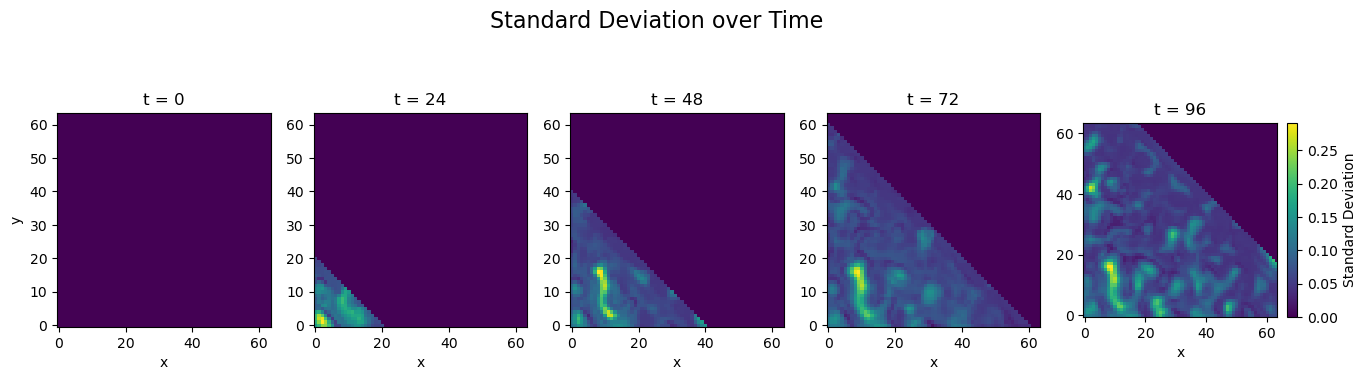

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

t0 = 0
t1 = wds.shape[1] // 4
t2 = wds.shape[1] // 2
t3 = wds.shape[1] // 4 * 3
t4 = -1
t = [t0, t1, t2, t3, t4]

titel = [f"t = {np.arange(0, dur, 5+1)[i]}" for i in t]

fig, axs = plt.subplots(1, 5, figsize=(16, 4))  # Adjusted figure size

for i, ax in enumerate(axs.ravel()):
    im = ax.imshow(np.std(wds[:, t[i], :, :], axis=0), origin="lower", cmap='viridis')  # Using a colormap
    ax.set_xlabel("x")
    ax.set_title(titel[i])

axs[0].set_ylabel("y")
fig.suptitle("Standard Deviation over Time", y=1.02, fontsize=16)  # Added figure title

# Add a vertical colorbar spanning the entire height
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Standard Deviation')